In [4]:
import os
import struct
import random
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from torch.utils.data import Dataset, DataLoader
import torchvision
import array
#import datalaoder

import datetime
import time
from pathlib import Path
from typing import Dict, List, Optional, Union

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import utils as vutils


from myDataloader import EMnistDataset

In [2]:
!pwd

/mnt/tapioca/Workspace/hw/A4_gans


In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [5]:
# %%
def show_images(real_imgs, fake_imgs: None, nrow=6, ncol=6, figsize=(5, 5), save: bool = False, show: bool = True, name=""):
    # compare and show n*m images from generator in one figure and optionally save it
    for imgs, label in zip([imgs for imgs in [real_imgs, fake_imgs] if fake_imgs is not None], ["real", "fake"]):
        imgs = imgs[:nrow * ncol]
        imgs = imgs.view(imgs.size(0), opt.channels, opt.img_size, opt.img_size)
        plt.figure(figsize=figsize)
        plt.imshow(np.transpose(vutils.make_grid(imgs, nrow=nrow, padding=2, normalize=True).cpu(), (1, 2, 0)))
        plt.axis('off')
        plt.title(name + label + " images")
        if save:
            plt.savefig(gen_img_root / (name + label + " images.png"))
        if show:
            plt.show()

In [6]:
!ls data

EMNIST		 my_test_label.npy  my_train_label.npy
my_test_img.npy  my_train_img.npy


In [7]:
train_label_filepath = r'data/my_train_label.npy'
train_img_filepath = r'data/my_train_img.npy'
test_label_filepath = r'data/my_test_label.npy'
test_img_filepath = r'data/my_test_img.npy'

In [ ]:
dataloader = DataLoader(
    EMnistDataset(img_dir="data/my_test_img.npy",label_dir="data/my_test_label.npy",
                  transform=transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize([0.5], [0.5])])),
    batch_size=64,
    shuffle=False,
)

('I', 'a', '0', '3', 'X', 'U', 'O', 'e', '5', '8', '2', '4', '2', 'l', '2', '3', '7', 'W', '7', '5', '3', 'y', 'I', 'k', 'I', 'a', 'x', 'C', 'b', '7', 'r', '7', 'F', '1', '9', 'c', 'h', 'i', '8', '5', 'e', '7', 'h', 'J', '7', 't', 'O', 'O', 'U', '6', '8', '4', 'l', '5', '9', 't', 'w', '1', '8', 'f', 'K', 'T', '0', 'S')
0.2765028476715088


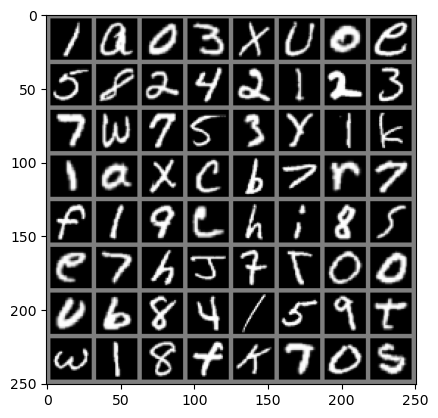

In [12]:
start = time.time()
for i, data in enumerate(dataloader):
    a = 1
    # print(data.shape)
    imshow(torchvision.utils.make_grid(data[0], padding=3))
    print(data[1])
    if i == 0:
        break
print(time.time() - start)

In [8]:
checkpoint_root = Path("dcGAN_2")
gen_img_root = Path("dcGAN_2/images")
weights_root = Path("dcGAN_2/weights")
checkpoint_root.mkdir(exist_ok=True)
gen_img_root.mkdir(exist_ok=True)
weights_root.mkdir(exist_ok=True)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


# %%
class Parse:
    def __init__(self) -> None:
        self.n_epochs = 200
        self.batch_size = 1536
        self.lr = 0.0002
        self.b1 = 0.5
        self.b2 = 0.999
        self.n_cpu = 8
        self.latent_dim = 100
        self.img_size = 32
        self.channels = 1
        self.sample_interval = 100


opt = Parse()

# %%
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True

torch.cuda.set_device(7)
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))


# %%
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.init_size = opt.img_size // 4
        self.l1 = nn.Sequential(nn.Linear(opt.latent_dim, 128 * self.init_size**2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, opt.channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2**4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size**2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)

        return validity


# %%
# Loss function
adversarial_loss = nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)
# Configure data loader

dataloader = DataLoader(
    EMnistDataset(img_dir=train_img_filepath,
                  transform=transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize([0.5], [0.5]),
                                                transforms.Resize(32)])),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=8,
    pin_memory=True
)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

# record trianing loss
record: Dict[str, List[float]] = {"D_loss": [], "G_loss": []}

def to_td(second: Union[int, float]) -> str:
    # convert seconds to time delta
    return str(datetime.timedelta(seconds=int(second)))


# %%
#  Training

training_start = time.time()
for epoch in range(opt.n_epochs):
    loss_d_e = 0
    loss_g_e = 0
    for i, data in enumerate(dataloader):
        #imgs = data[0][1]
        imgs = data
        # Configure input
        real_imgs = imgs.to(device)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = torch.randn(imgs.size(0), opt.latent_dim).to(device)

        # Generate a batch of images
        fake_imgs = generator(z)

        # Loss measures generator's ability to fool the discriminator
        fake_pred = discriminator(fake_imgs)
        g_loss = adversarial_loss(fake_pred, torch.ones_like(fake_pred))

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_pred = discriminator(real_imgs)
        fake_pred = discriminator(fake_imgs.detach())
        real_loss = adversarial_loss(real_pred, torch.ones_like(real_pred))
        fake_loss = adversarial_loss(fake_pred, torch.zeros_like(fake_pred))
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        loss_d_e += d_loss.item()
        loss_g_e += g_loss.item()
        batches_done = epoch * len(dataloader) + i

        if batches_done % (opt.sample_interval // 100 + 1) == 0:
            diff = time.time() - training_start
            a_td = to_td(diff)
            al_td = to_td(diff * opt.n_epochs * len(dataloader) / (epoch * len(dataloader) + i + 1))
            per_df = diff / (epoch + 1 + i / len(dataloader))

            print(f"\r E{epoch+1:03}B{i+1:03}, [{a_td}/{al_td}] {per_df:5.2f}s/epoch",
                  f"D_loss: {d_loss.item():6.4f} = r{real_loss.item():6.4f} + f{fake_loss.item():6.4f}",
                  f" G_loss: {g_loss.item():6.4f}",
                  end="")

        if batches_done % opt.sample_interval == 0:
            #show_images(real_imgs, fake_imgs, save=True, name=f"E{epoch+1:03}B{i+1:03} ")
            if batches_done > 10:
                torch.save(generator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}G.pth")
                torch.save(discriminator.state_dict(), weights_root / f"E{epoch+1:03}B{i+1:03}D.pth")

    record["D_loss"].append(loss_d_e / len(dataloader))
    record["G_loss"].append(loss_g_e / len(dataloader))

device 7 NVIDIA GeForce RTX 3090
img len: (697932, 28, 28)
 E014B204, [0:18:06/4:29:22] 75.23s/epoch D_loss: 0.6136 = r0.6982 + f0.5291  G_loss: 0.937350.6895939

KeyboardInterrupt: 

In [ ]:
weights_root = './dcGAN_1/weights'
weight = 'E200B965G.pth'
PATH = os.path.join(weights_root, weight)
for i, imgs in enumerate(dataloader):
    real_imgs = imgs.to(device)
    z = torch.randn(imgs.size(0), opt.latent_dim).to(device)
    generator.load_state_dict(torch.load(PATH))
    fake_imgs = generator(z)


    show_images(real_imgs, fake_imgs, save=True, name=weight)
    break

In [7]:
!ls

__pycache__  cycle_gan.py  data_preprocess.py  myDataloader.py	utils.py
cycle_GAN_1  data	   dcGAN_1	       test.py


In [5]:
a = np.load('data/my_test_img.npy',allow_pickle=True)

In [6]:
a[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  29,  49,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   4, 121, 122,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   9, 136, 123,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,  34, 200, 126,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  